1. clean data
2. one hot encode categorical features
3. apply scaler to numerical features
4. create model
5. hyperparameter tune the model using exhaustive search with metric of mse using cross validation
6. evaluate final model using cross validation (mse)

https://www.glassdoor.com/Salaries/embedded-systems-engineer-salary-SRCH_KO0,25.htm
(example for large ranges of salary predictions)

# **Imports**

In [75]:
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# **Data Cleaning**

In [76]:
# read in csv as dataframe
df_salaries_uncleaned = pd.read_csv("data/Salary_Data.csv")

# drop null entries
df_salaries_cleaned = df_salaries_uncleaned.dropna()

# standardize the degree names
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Bachelor's Degree", "Bachelor's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("Master's Degree", "Master's")
df_salaries_cleaned["Education Level"] = df_salaries_cleaned["Education Level"].replace("phD", "PhD")

# normalize data types
df_salaries_cleaned["Age"] = df_salaries_cleaned["Age"].astype("int")
df_salaries_cleaned["Years of Experience"] = df_salaries_cleaned["Years of Experience"].astype("int")

# drop duplicate entries
df_salaries_cleaned = df_salaries_cleaned.drop_duplicates()

# show data summary
df_salaries_cleaned.info()
df_salaries_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1786 entries, 0 to 6631
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1786 non-null   int32  
 1   Gender               1786 non-null   object 
 2   Education Level      1786 non-null   object 
 3   Job Title            1786 non-null   object 
 4   Years of Experience  1786 non-null   int32  
 5   Salary               1786 non-null   float64
dtypes: float64(1), int32(2), object(3)
memory usage: 83.7+ KB


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32,Male,Bachelor's,Software Engineer,5,90000.0
1,28,Female,Master's,Data Analyst,3,65000.0
2,45,Male,PhD,Senior Manager,15,150000.0
3,36,Female,Bachelor's,Sales Associate,7,60000.0
4,52,Male,Master's,Director,20,200000.0


# **Data Preprocessing**

In [77]:
# separate categorical and numerical columns
categorical_columns = ["Gender", "Education Level", "Job Title"]
numerical_columns = ["Age", "Years of Experience"]

# separate the data into features and target values
X_data = df_salaries_cleaned[["Age", "Gender", "Education Level", "Job Title", "Years of Experience"]]
y_data = df_salaries_cleaned["Salary"]

# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# transform table to standardize columns
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="drop"
)

# **Linear Regression**

### Hyperparameter Tuning

In [78]:
# create tuning pipeline
pipeline = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

# hyperparameters to tune
param_grid = {
    "selectkbest__k": [1, 2, 3, 4, 5],
}

# create an exhaustive search using cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search.fit(X_data, y_data)

print("Best Features:", grid_search.best_estimator_.feature_names_in_)

Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [79]:
# create model pipeline
pipeline = make_pipeline(
    ct,
    LinearRegression()
)

# train model on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('linearregression', LinearRegression())])

### Model Evaluations

In [80]:
# predict salaries on testing data
y_pred = pipeline.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 503620783.2494343
Root Mean Squared Error (RMSE): 22441.496903046245
R2 Score: 0.8231839739213134


### Model Visualizations

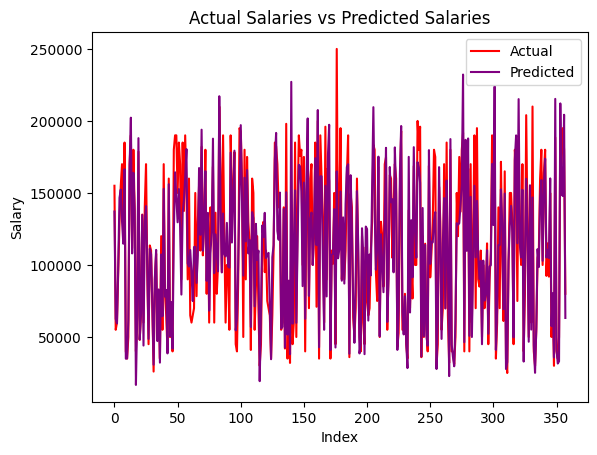

<Axes: xlabel='x'>

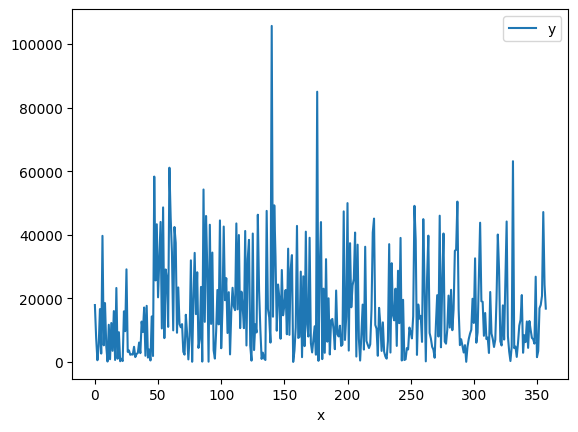

In [81]:
import matplotlib.pyplot as plt

df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred))]})
df_predicted["y"] = y_pred

ax = plt.gca()

df_actual.plot(x="x", y="y", kind="line", color="red", label="Actual", ax=ax)
df_predicted.plot(x="x", y="y", kind="line", color="purple", label="Predicted", ax=ax)

ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred

df_diff = df_diff.apply(abs)

df_diff.plot(x="x", y="y")

# **K-Nearest Neighbors**

### Hyperparameter Tuning

In [82]:
# create tuning pipeline
pipeline = make_pipeline(
    ct,
    SelectKBest(score_func=f_regression),
    KNeighborsRegressor(metric="euclidean")
)

# hyperparameters to tune
param_grid = {
    "selectkbest__k": [1, 2, 3, 4, 5],
    "kneighborsregressor__n_neighbors": [n for n in range(1, 10)]
}

# create an exhaustive search using cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")

# perform exhaustive search to tune hyperparameters
grid_search.fit(X_data, y_data)

print("Best N-Neighbors:", grid_search.best_params_["kneighborsregressor__n_neighbors"])
print("Best Features:", grid_search.best_estimator_.feature_names_in_)

Best N-Neighbors: 9
Best Features: ['Age' 'Gender' 'Education Level' 'Job Title' 'Years of Experience']


### Model Training

In [83]:
# create model pipeline
pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=9, metric="euclidean")
)

# train model on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Job Title']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=9))])

### Model Evaluations

In [84]:
# predict salaries on testing data
y_pred = pipeline.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 419640080.43175393
Root Mean Squared Error (RMSE): 20485.11851153793
R2 Score: 0.8526687264045383


### Model Visualizations

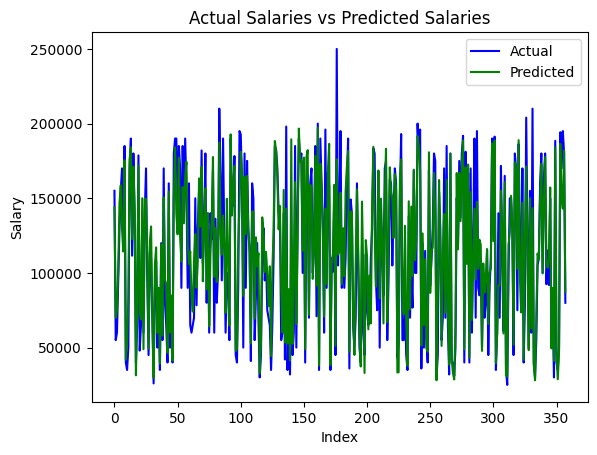

<Axes: xlabel='x'>

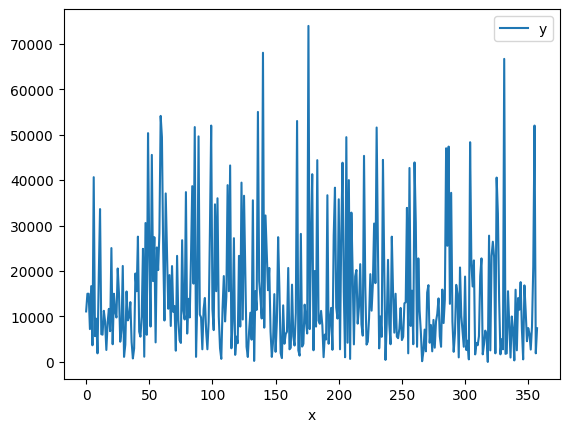

In [85]:
import matplotlib.pyplot as plt
import numpy as np

df_actual = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_actual["y"] = list(y_test)

df_predicted = pd.DataFrame({"x": [n for n in range(len(y_pred))]})
df_predicted["y"] = y_pred

ax = plt.gca()

df_actual.plot(x="x", y="y", kind="line", color="blue", label="Actual", ax=ax)
df_predicted.plot(x="x", y="y", kind="line", color="green", label="Predicted", ax=ax)

ax.set_xlabel("Index")
ax.set_ylabel("Salary")
ax.set_title("Actual Salaries vs Predicted Salaries")

plt.show()

df_diff = pd.DataFrame({"x": [n for n in range(len(y_test))]})
df_diff["y"] = y_test.to_numpy() - y_pred

df_diff = df_diff.apply(abs)

df_diff.plot(x="x", y="y")